### Text Preprocessing
Tokenizer, Padding

In [1]:
# import modules
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [2]:
sentences = [
    'Today I was learning Apache Spark.',
    'I ate eggs and bread today.',
    'today was good day.'
]

#### Tokenizer

In [3]:
# tokenizer - turning words into numerical values
MAX_VOCAB_SIZE = 20000
tokenizer = Tokenizer(num_words = MAX_VOCAB_SIZE)
tokenizer.fit_on_texts(sentences)
sequences = tokenizer.texts_to_sequences(sentences)

print(sequences)

[[1, 2, 3, 4, 5, 6], [2, 7, 8, 9, 10, 1], [1, 3, 11, 12]]


In [4]:
tokenizer.word_index

{'today': 1,
 'i': 2,
 'was': 3,
 'learning': 4,
 'apache': 5,
 'spark': 6,
 'ate': 7,
 'eggs': 8,
 'and': 9,
 'bread': 10,
 'good': 11,
 'day': 12}

#### Padding

In [5]:
# padding - obtaining same shapes for all sentences
data = pad_sequences(sequences)
print(data)

[[ 1  2  3  4  5  6]
 [ 2  7  8  9 10  1]
 [ 0  0  1  3 11 12]]


In [6]:
# more parameters for padding
print(pad_sequences(sequences, maxlen = 8))

[[ 0  0  1  2  3  4  5  6]
 [ 0  0  2  7  8  9 10  1]
 [ 0  0  0  0  1  3 11 12]]


In [7]:
print(pad_sequences(sequences, padding = 'post'))

[[ 1  2  3  4  5  6]
 [ 2  7  8  9 10  1]
 [ 1  3 11 12  0  0]]


In [8]:
print(pad_sequences(sequences, maxlen = 4, truncating = 'post'))

[[ 1  2  3  4]
 [ 2  7  8  9]
 [ 1  3 11 12]]


### Spam Detection using LSTM
All data is the same.

In [41]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import Dense, Input, GlobalMaxPooling1D, LSTM, Embedding
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

In [128]:
# upload the data
!wget https://raw.githubusercontent.com/Islambekkurakbay/Spam_Detection/main/spam.csv

--2023-03-11 00:31:06--  https://raw.githubusercontent.com/Islambekkurakbay/Spam_Detection/main/spam.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 503663 (492K) [text/plain]
Saving to: ‘spam.csv.1’

spam.csv.1          100%[===================>] 491.86K  --.-KB/s    in 0.01s   

2023-03-11 00:31:07 (45.5 MB/s) - ‘spam.csv.1’ saved [503663/503663]



In [12]:
df = pd.read_csv('spam.csv', encoding = 'ISO-8859-1')
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


#### Data Preprocessing

In [14]:
# remove extra columns
df = df.drop(['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], axis=1)
df.head()

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [15]:
# rename columns
df.columns = ['result', 'data']
df.head()

,result,data
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [16]:
# turn result column into binary 0/1
df['binary_result'] = df['result'].map({'ham': 0, 'spam': 1})
Y = df['binary_result'].values
print(Y[:5])

# def replace_string(data, column):
#   strs = data[column].unique().tolist()
# # print(strs)
#   x = len(strs)
#   ints = np.linspace(0, x-1, x)
#   data.replace(strs, ints, inplace = True)

[0 0 1 0 0]


In [17]:
df.head()

,result,data,binary_result
0,ham,"Go until jurong point, crazy.. Available only ...",0
1,ham,Ok lar... Joking wif u oni...,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,ham,U dun say so early hor... U c already then say...,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",0


#### Train/Test Data Preparation
train, test splitting

In [24]:
X_train, X_test, y_train, y_test = train_test_split(df['data'], Y, test_size = 0.25)

In [26]:
X_train.shape

(4179,)

In [25]:
y_train.shape

(4179,)

In [27]:
X_test.shape

(1393,)

In [28]:
y_test.shape

(1393,)

#### Convert sentences to sequences

In [33]:
# tokenizer
MAX_VOCAB_SIZE = 20000
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)
tokenizer.fit_on_texts(X_train)
seq_train = tokenizer.texts_to_sequences(X_train)
seq_test = tokenizer.texts_to_sequences(X_test)
print(seq_train[:5])

[[1905, 1, 59, 1906, 2443, 214, 370], [601, 401, 2, 30, 101, 109, 65, 160, 63, 44, 43, 82, 70, 3, 494, 9, 4, 2444, 267], [55, 430, 11, 69, 109, 293, 2445, 21, 3, 402, 10, 47, 28, 3, 28, 21, 3, 281, 983, 7, 3729, 831, 27, 141, 7, 3730, 33, 11, 69], [899, 80, 220, 42, 11, 832, 22, 301, 517, 56, 17, 294, 80, 1, 833, 164, 518, 32, 84, 1059, 11, 358, 19, 11, 358, 340, 1059, 770], [132, 3, 21, 359, 4, 55, 135, 37, 1060, 9]]


In [34]:
# get unique words size
word2idx = tokenizer.word_index
V = len(word2idx)
print(f"Found {V} unique tokens")

Found 7675 unique tokens


In [38]:
# padding
data_train = pad_sequences(seq_train)
data_test = pad_sequences(seq_test)
print(data_train[0])

[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
 1905    1   59 1906 2443  214  370]


In [48]:
# get the longest sequence
print(data_train.shape)
print(data_test.shape)

# here the test data has shorter sequences

(4179, 189)
(1393, 98)


In [49]:
# resolve the problem
# padding
data_train = pad_sequences(seq_train)
data_test = pad_sequences(seq_test, maxlen = data_train.shape[1])

# get the longest sequence
print(data_train.shape)
print(data_test.shape)

(4179, 189)
(1393, 189)


#### Create the model

In [50]:
T = len(data_train[0])
D = 20
M = 15

i = Input(shape = (T, ))
x = Embedding(V+1, D)(i)
x = LSTM(M, return_sequences = True)(x)
x = GlobalMaxPooling1D()(x)
x = Dense(1, activation = 'sigmoid')(x)

model = Model(i, x)


#### Compile and Fit

In [51]:
model.compile(
    loss = 'binary_crossentropy',
    optimizer = 'adam',
    metrics = ['accuracy'],
)

r = model.fit(
    data_train, y_train,
    epochs = 10,
    validation_data = (data_test, y_test),
)

Epoch 1/10
131/131 [==============================] - 10s 60ms/step - loss: 0.4493 - accuracy: 0.8662 - val_loss: 0.3755 - val_accuracy: 0.8650
Epoch 2/10
131/131 [==============================] - 8s 64ms/step - loss: 0.2763 - accuracy: 0.8662 - val_loss: 0.2175 - val_accuracy: 0.8650
Epoch 3/10
131/131 [==============================] - 12s 92ms/step - loss: 0.1713 - accuracy: 0.9332 - val_loss: 0.1550 - val_accuracy: 0.9785
Epoch 4/10
131/131 [==============================] - 15s 116ms/step - loss: 0.1137 - accuracy: 0.9926 - val_loss: 0.1160 - val_accuracy: 0.9892
Epoch 5/10
131/131 [==============================] - 11s 84ms/step - loss: 0.0784 - accuracy: 0.9955 - val_loss: 0.0910 - val_accuracy: 0.9856
Epoch 6/10
131/131 [==============================] - 13s 101ms/step - loss: 0.0580 - accuracy: 0.9966 - val_loss: 0.0824 - val_accuracy: 0.9835
Epoch 7/10
131/131 [==============================] - 13s 96ms/step - loss: 0.0467 - accuracy: 0.9966 - val_loss: 0.0753 - val_accuracy

#### Visualize results

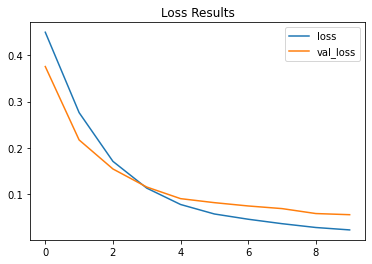

In [52]:
plt.plot(r.history['loss'], label = 'loss')
plt.plot(r.history['val_loss'], label = 'val_loss')
plt.title("Loss Results")
plt.legend()
plt.show()

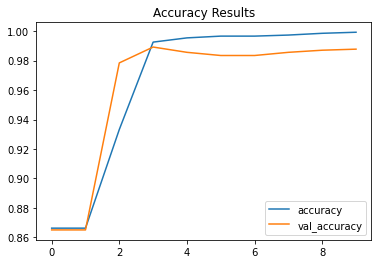

In [86]:
plt.plot(r.history['accuracy'], label = 'accuracy')
plt.plot(r.history['val_accuracy'], label = 'val_accuracy')
plt.title("Accuracy Results")
plt.legend()
plt.show()

#### Predictions

In [125]:
# Predict data  
def predict_spam(string):
  numericals = tokenizer.texts_to_sequences([string])
  x = pad_sequences(numericals, maxlen=T)  
  x = model.predict(x)
  # x = np.argmax(x)
  return(x)

predict_spam("Hello my name is spam")

1/1 [==============================] - 0s 56ms/step


array([[0.01083794]], dtype=float32)

In [126]:
predict_spam("WINNER!! As a valued network customer you have been selected to receivea å£900 prize reward! To claim call 09061701461. Claim code KL341. Valid 12 hours only")

1/1 [==============================] - 0s 44ms/step


array([[0.9348417]], dtype=float32)

In [127]:
predict_spam("Had your mobile 11 months or more? U R entitled to Update to the latest colour mobiles with camera for Free! Call The Mobile Update Co FREE on 08002986030")

1/1 [==============================] - 0s 70ms/step


array([[0.9347382]], dtype=float32)